# SLTimer Example Analysis of TDC2 Data

This notebook shows you how to find the estimation of a lens time delay from TDC2 light curve data using the `PyCS` code. For a detailed tutorial through the `PyCS` code, please visit this [address.](https://github.com/DarkEnergyScienceCollaboration/SLTimer/blob/master/notebooks/PyCS_Tutorial.ipynb)

First, we'll import `SLTimer`, as well as a few other important commands. 

In [1]:
from __future__ import print_function
%matplotlib inline

import sys
sys.path.append('../python')
import desc.sltimer

%load_ext autoreload
%autoreload 2

## Data Munging

Now, let's start a timer object, and download some data to use. The output should show 1005 imported points if we are using the correct `tdc2-gateway-example.txt` file.

In [2]:
timer = desc.sltimer.SLTimer()

In [3]:
url = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-example.txt"
timer.download(url, and_read=True, format='tdc2')

Downloaded datafile: http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-example.txt
Checking header of "tdc2-gateway-example.txt"...
Reading "tdc2-gateway-example.txt"...
[Image/A] with 1005 points imported (0 of them masked).
Checking header of "tdc2-gateway-example.txt"...
Reading "tdc2-gateway-example.txt"...
[Image/B] with 1005 points imported (0 of them masked).
Checking header of "tdc2-gateway-example.txt"...
Reading "tdc2-gateway-example.txt"...
[Image/C] with 1005 points imported (0 of them masked).
Checking header of "tdc2-gateway-example.txt"...
Reading "tdc2-gateway-example.txt"...
[Image/D] with 1005 points imported (0 of them masked).


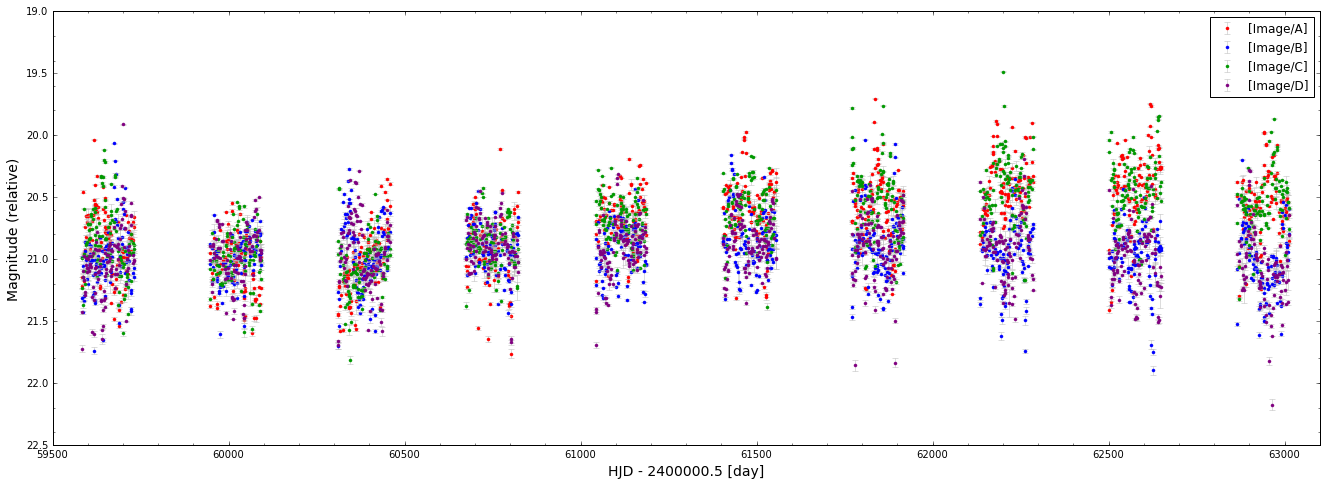

In [4]:
timer.display_light_curves(jdrange=(59500,63100))

We're now ready to analyze this data. We'll start with it as-is, and then later try "whitening" it.

## Spline Modeling

The following lines will run an entire free-knot spline technique on your data with a complete error analysis using the `TDC2` method. Below, you can specify how the time delays will be analyzed. The default is listed below according to the `PyCS` tutorial. See the bottom of the page for alternate methods. 

In [5]:
timer.estimate_time_delays(method='pycs',microlensing='spline',agn='spline',error=None)

You are using the pycs method.
Starting opt_rough on initial delays :
AB   +0.00 | AC   +0.00 | AD   +0.00 | BC   +0.00 | BD   +0.00 | CD   +0.00
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/21~|
Working on the spline ML of [Image/B](0.000,-0.257,0)|~3/u/21~|
Working on the spline ML of [Image/C](0.000,-0.015,0)|~3/u/21~|
Working on the spline ML of [Image/D](0.000,-0.253,0)|~3/u/21~|
Done !
First spline and ML opt done.
AB   +6.00 | AC   +2.00 | AD   +1.00 | BC   -4.00 | BD   -5.00 | CD   -1.00    (Iteration  1, r2 = 46871685.5)
AB  +10.00 | AC   +4.00 | AD   +3.00 | BC   -6.00 | BD   -7.00 | CD   -1.00    (Iteration  2, r2 = 45905121.9)
AB  +12.00 | AC   +5.00 | AD   +4.00 | BC   -7.00 | BD   -8.00 | CD   -1.00    (Iteration  3, r2 = 45591143.2)
AB  +14.00 | AC   +6.00 | AD   +5.00 | BC   -8.00 | BD   -9.00 | CD   -1.00    (Iteration  4, r2 = 45345660.4)
AB  +16.00 | AC   +7.00 | AD   +6.00 | BC   -9.00 | BD  -10.00 | CD   -1.00    (I

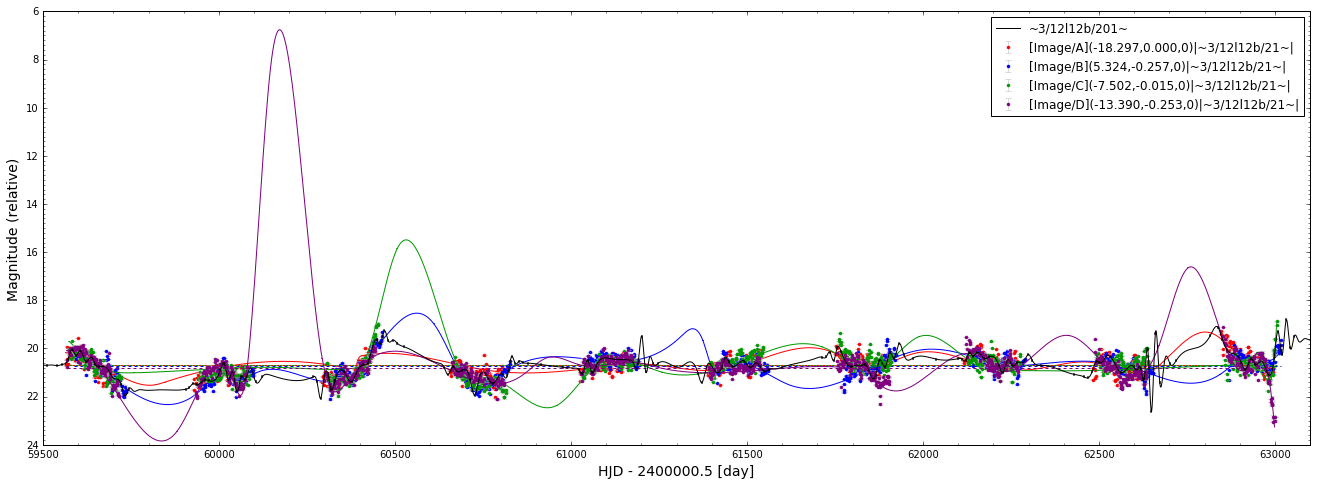

In [6]:
timer.display_light_curves(jdrange=(59500,63100))

While the time delays have been estimated, we can see that the different images' light curves are not shifted and microlensing-corrected terribly well. 

In [7]:
# timer.estimate_uncertainties(n=3,npkl=5)

## Whitening the Light Curves

In the above analysis we ignored the fact that the magnitudes were measured in 6 different filters, and just used them all as if they were from the same filter. By offsetting the light curves to a common mean, we should get a set of points that look more like they were taken in one filter. This process is known as "whitening."

In [8]:
wtimer = desc.sltimer.SLTimer()
wtimer.download(url, and_read=True, format='tdc2')

Downloaded datafile: http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-example.txt
Checking header of "tdc2-gateway-example.txt"...
Reading "tdc2-gateway-example.txt"...
[Image/A] with 1005 points imported (0 of them masked).
Checking header of "tdc2-gateway-example.txt"...
Reading "tdc2-gateway-example.txt"...
[Image/B] with 1005 points imported (0 of them masked).
Checking header of "tdc2-gateway-example.txt"...
Reading "tdc2-gateway-example.txt"...
[Image/C] with 1005 points imported (0 of them masked).
Checking header of "tdc2-gateway-example.txt"...
Reading "tdc2-gateway-example.txt"...
[Image/D] with 1005 points imported (0 of them masked).


In [9]:
wtimer.whiten()

whiten: before whitening, means = {'A': 20.711532518124155, 'C': 20.705871125607601, 'B': 20.944033297904049, 'D': 20.951768266216945}
whiten: before whitening, scatters = {'A': 0.331681304768568, 'C': 0.31580549938847502, 'B': 0.24460380814890625, 'D': 0.25208811918271135}
whiten: detected bands: ['g' 'i' 'r' 'u' 'y' 'z']
whiten: after whitening, means = {'A': 20.711532518124155, 'C': 20.705871125607604, 'B': 20.944033297904053, 'D': 20.951768266216941}
whiten: after whitening, scatters = {'A': 0.32682298947866339, 'C': 0.31352510413054496, 'B': 0.24221918986954338, 'D': 0.24939575627218172}


The change brought about by whitening is pretty subtle: the means of each image's light curve stay the same (by deisgn), but the scatter in each image's light curve is somewhat reduced. 

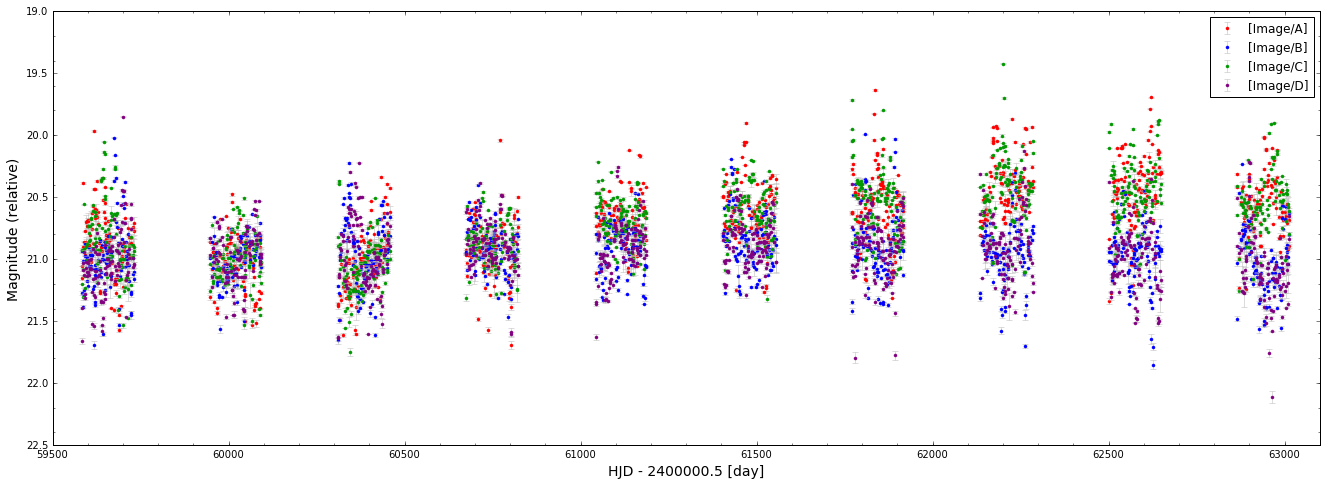

In [10]:
wtimer.display_light_curves(jdrange=(59500,63100))

In [11]:
wtimer.estimate_time_delays(method='pycs',microlensing='spline',agn='spline',error=None)

You are using the pycs method.
Starting opt_rough on initial delays :
AB   +0.00 | AC   +0.00 | AD   +0.00 | BC   +0.00 | BD   +0.00 | CD   +0.00
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/21~|
Working on the spline ML of [Image/B](0.000,-0.247,0)|~3/u/21~|
Working on the spline ML of [Image/C](0.000,0.000,0)|~3/u/21~|
Working on the spline ML of [Image/D](0.000,-0.256,0)|~3/u/21~|
Done !
First spline and ML opt done.
AB   +6.00 | AC   +1.00 | AD   +0.00 | BC   -5.00 | BD   -6.00 | CD   -1.00    (Iteration  1, r2 = 46440879.5)
AB  +11.00 | AC   +3.00 | AD   +1.00 | BC   -8.00 | BD  -10.00 | CD   -2.00    (Iteration  2, r2 = 45261640.5)
AB  +14.00 | AC   +5.00 | AD   +3.00 | BC   -9.00 | BD  -11.00 | CD   -2.00    (Iteration  3, r2 = 44700592.2)
AB  +16.00 | AC   +6.00 | AD   +4.00 | BC  -10.00 | BD  -12.00 | CD   -2.00    (Iteration  4, r2 = 44418231.0)
AB  +18.00 | AC   +7.00 | AD   +5.00 | BC  -11.00 | BD  -13.00 | CD   -2.00    (It

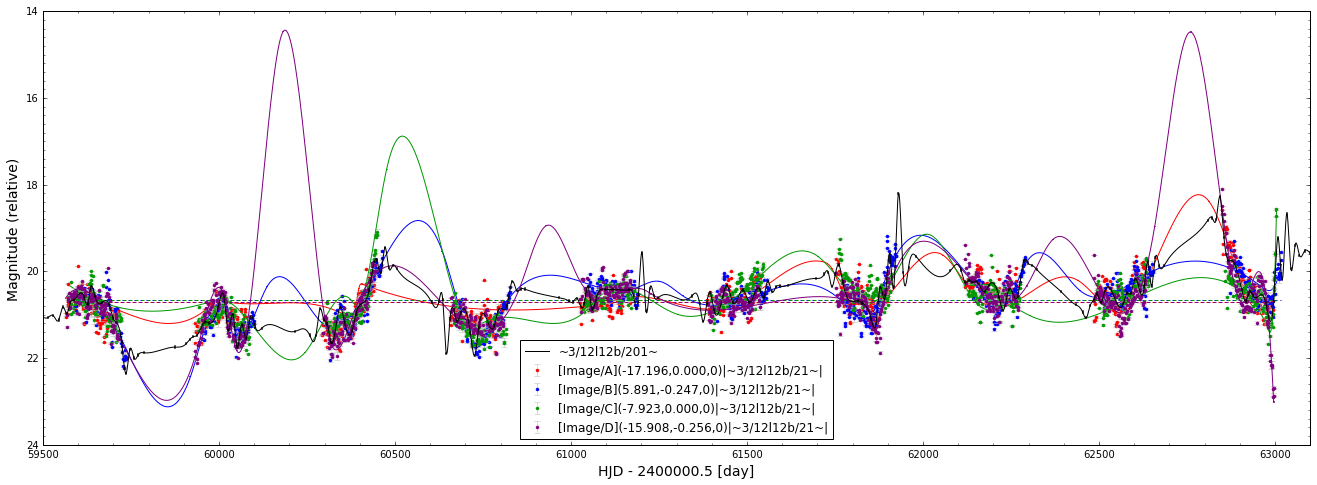

In [12]:
wtimer.display_light_curves(jdrange=(59500,63100))

How does the plot compare? Note that the y axis scale is different: the shifted light curves seem to match up better now.

Now let's look at the estimated time delays - by how much do they differ, between the unwhitened and whitened data?

#### Whitened:

In [13]:
wtimer.report_time_delays()

Time Delays:
AB  +23.09
AC   +9.27
AD   +1.29
BC  -13.81
BD  -21.80
CD   -7.98


#### Unwhitened:

In [14]:
timer.report_time_delays()

Time Delays:
AB  +23.62
AC  +10.79
AD   +4.91
BC  -12.83
BD  -18.71
CD   -5.89


## Conclusions

The above demo shows that:

* We can read in and analyze multi-filter TDC2 data with `PyCS`
* Whitening the data may lead to improved estimates, but more tests will be needed

Our next step is to check the true time delays in this system and the rest of the TDC2 gateway data set.